In [0]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import math
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
DATA = "CK"
DATA_PATH = "drive/My Drive/FER/datasets/CK+48/"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/Multi-Input-Model/"

In [0]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

fear has 75 number of images
sadness has 84 number of images
anger has 135 number of images
surprise has 249 number of images
happy has 207 number of images

total images are 750


In [0]:
TOP_EMOTIONS = ["happy", "fear", "sadness", "anger", "surprise"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

750

In [0]:
%%time
print("loading images to numpy array, this will take few minutes...")

img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"loading {dir_} images to numpy arrays")
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)
img_arr.shape, img_label.shape

print("\n")

loading images to numpy array, this will take few minutes...
loading fear images to numpy arrays
loading sadness images to numpy arrays
loading anger images to numpy arrays
loading surprise images to numpy arrays
loading happy images to numpy arrays


CPU times: user 392 ms, sys: 272 ms, total: 664 ms
Wall time: 3min 31s


In [0]:
label_to_text

{0: 'fear', 1: 'sadness', 2: 'anger', 3: 'surprise', 4: 'happy'}

In [0]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'anger': 2, 'fear': 0, 'happy': 4, 'sadness': 1, 'surprise': 3}

In [0]:
img_arr = img_arr / 255.

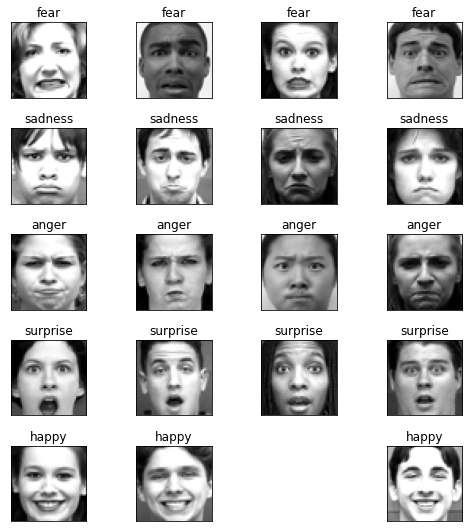

In [0]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((525, 48, 48, 1), (225, 48, 48, 1))

In [0]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

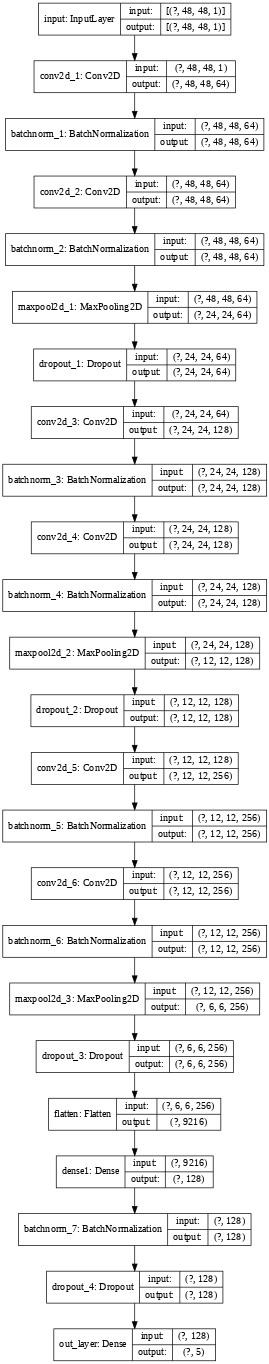

In [0]:
INPUT_SHAPE = (48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')

In [0]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

batch_size = 10
epochs = 60

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [0]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/60
53/52 [==============================] - 31s 593ms/step - loss: 2.1012 - accuracy: 0.3238 - val_loss: 1.6976 - val_accuracy: 0.3244 - lr: 0.0010
Epoch 2/60
53/52 [==============================] - 31s 589ms/step - loss: 1.3647 - accuracy: 0.5219 - val_loss: 1.6270 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 3/60
53/52 [==============================] - 31s 583ms/step - loss: 1.1245 - accuracy: 0.5905 - val_loss: 2.4385 - val_accuracy: 0.4044 - lr: 0.0010
Epoch 4/60
53/52 [==============================] - 31s 583ms/step - loss: 1.0723 - accuracy: 0.6400 - val_loss: 1.1363 - val_accuracy: 0.5422 - lr: 0.0010
Epoch 5/60
53/52 [==============================] - 31s 582ms/step - loss: 0.9288 - accuracy: 0.6590 - val_loss: 0.6236 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 6/60
53/52 [==============================] - 31s 583ms/step - loss: 0.7808 - accuracy: 0.7086 - val_loss: 0.3019 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/60
53/52 [==============================] - 30s 575ms/st

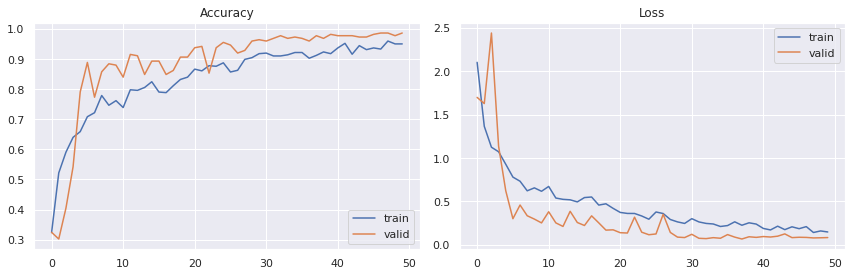

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [0]:
label_to_text

{0: 'fear', 1: 'sadness', 2: 'anger', 3: 'surprise', 4: 'happy'}

In [0]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'anger': 2, 'fear': 0, 'happy': 4, 'sadness': 1, 'surprise': 3}

test accuracy: 97.7778 %


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.89      1.00      0.94        25
           2       1.00      0.93      0.96        41
           3       1.00      1.00      1.00        75
           4       0.97      1.00      0.98        62

    accuracy                           0.98       225
   macro avg       0.97      0.97      0.97       225
weighted avg       0.98      0.98      0.98       225



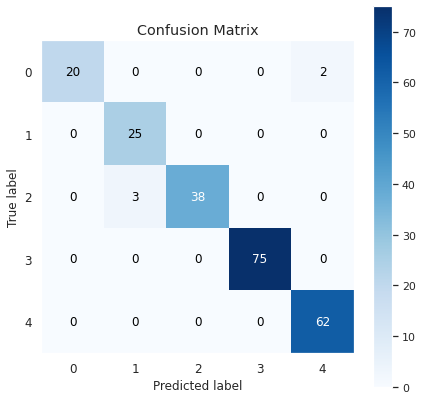

In [0]:
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [0]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f83ceebe710>),
 ('conv2d_2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f83cd5025c0>),
 ('conv2d_3',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f83cd4ce320>),
 ('conv2d_4',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f83cd4ddb00>),
 ('conv2d_5',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f83cd438ba8>),
 ('conv2d_6',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f83cd445f60>)]

## Let's Visualize What our CNN Learned

#### Plot Filters

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_4"]

CPU times: user 44.8 s, sys: 367 ms, total: 45.2 s
Wall time: 44.8 s


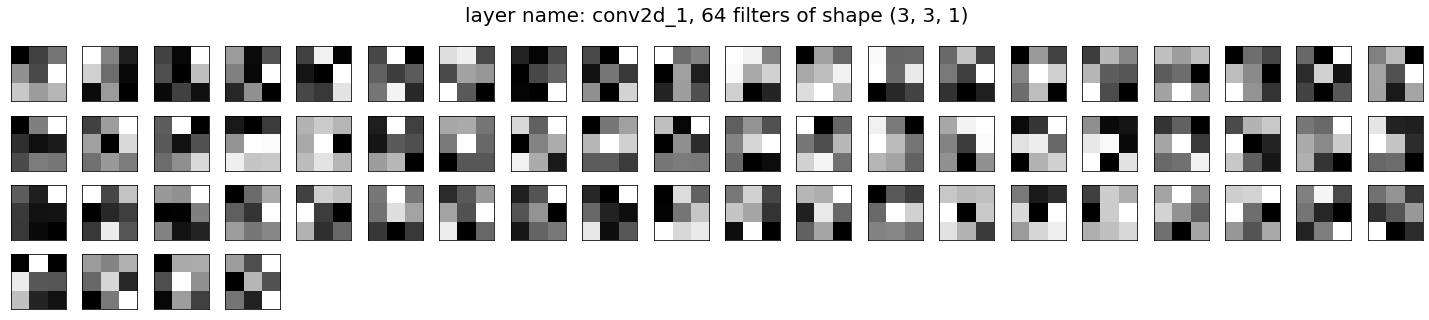

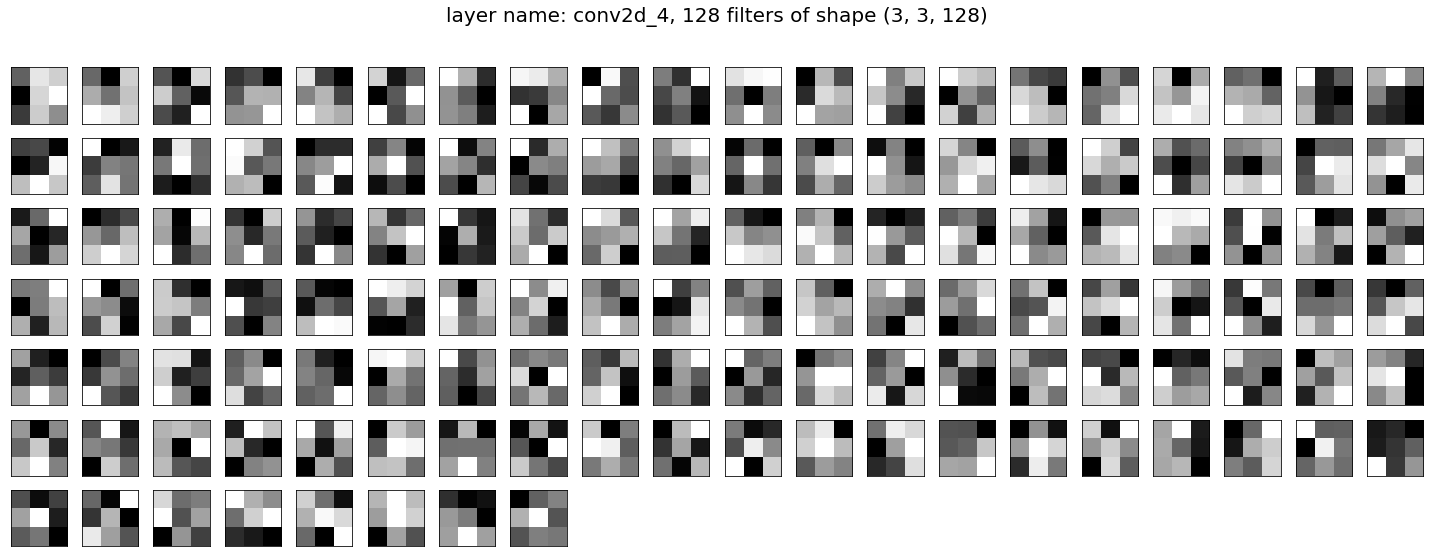

In [0]:
%%time

idx = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:        
        layer_output = layer[1].output
        filters, bias = layer[1].get_weights()     
        filters = (filters - filters.min()) / (filters.max() - filters.min())
    
        cols = 20
        rows = math.ceil(filters.shape[-1] / cols)
        fig = pyplot.figure(i, (20, rows))

        idx += 1
        for i,f in enumerate(np.rollaxis(filters, 3)):
            ax = pyplot.subplot(rows, cols, i+1)
            f = np.mean(f, axis=2)
            ax.imshow(f, cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, {filters.shape[3]} filters of shape {filters.shape[:-1]}", fontsize=20, y=1.1)
            pyplot.tight_layout()

#### Plot Feature Maps

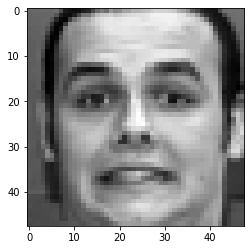

In [0]:
sns.reset_orig()
sample_img = X_test[0] # select a random image
pyplot.imshow(sample_img.reshape(48,48), cmap="gray")
pyplot.show()

In [0]:
sample_img = np.expand_dims(sample_img, axis=0)
sample_img.shape

(1, 48, 48, 1)

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_4"]

CPU times: user 44.9 s, sys: 474 ms, total: 45.4 s
Wall time: 44.9 s


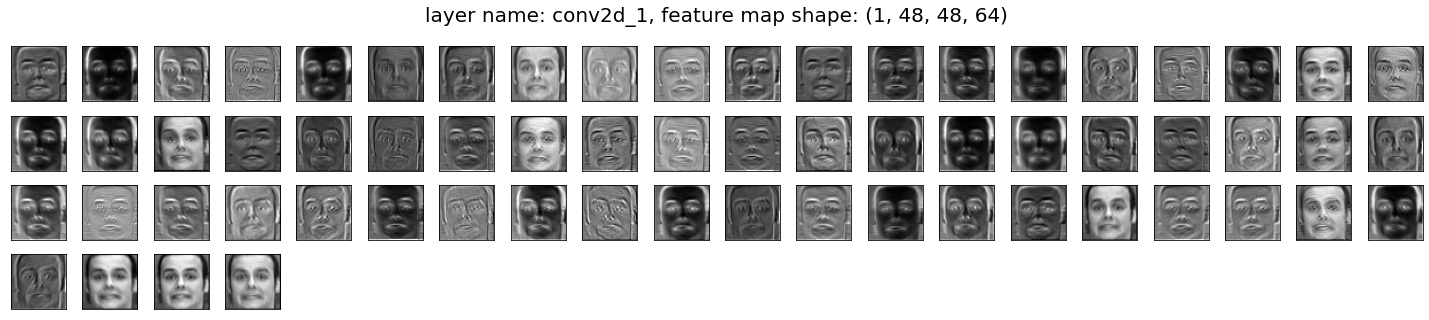

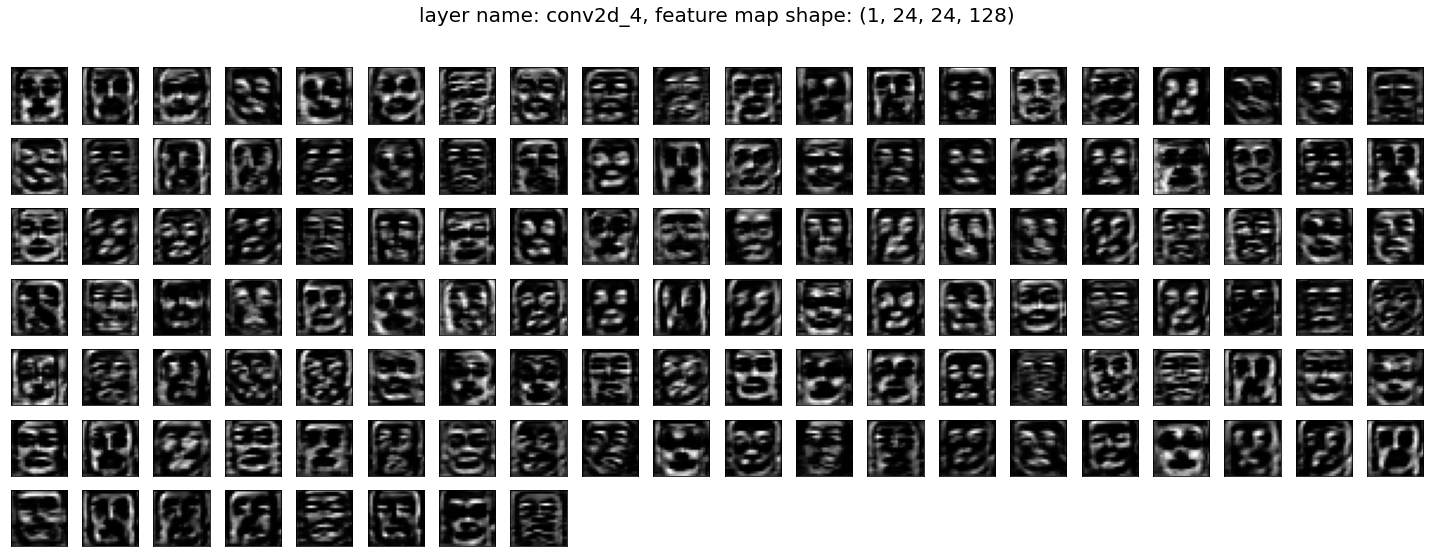

In [0]:
%%time

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(sample_img)

        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        fig = pyplot.figure(i, (20, rows))        
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

We can see that the first convolutional layer has detected many edges in the image and indeed this is what we expected.

#### Plot Class Activation Map (CAM) 
The following CAM is taken from [here](https://github.com/himanshurawlani/convnet-interpretability-keras/blob/master/Visualizing%20heatmaps/heatmap_visualization_using_gradcam.ipynb).

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_2", "conv2d_3", "conv2d_4", "conv2d_5", "conv2d_6"]

In [0]:
preds = model.predict(sample_img)
label_to_text[np.argmax(preds[0])]

'fear'

In [0]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>

In [0]:
heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([sample_img])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

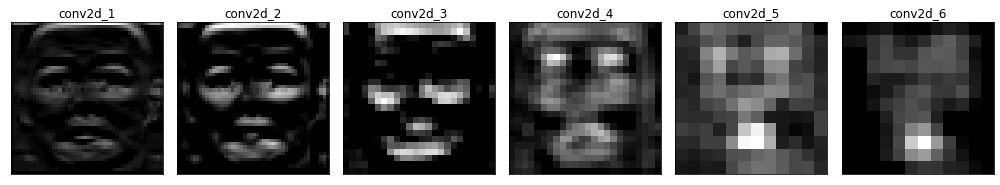

In [0]:
fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

We can see that our model focuses on important aspects of the image i.e., `lips`, `eyes` and `eyebrows`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


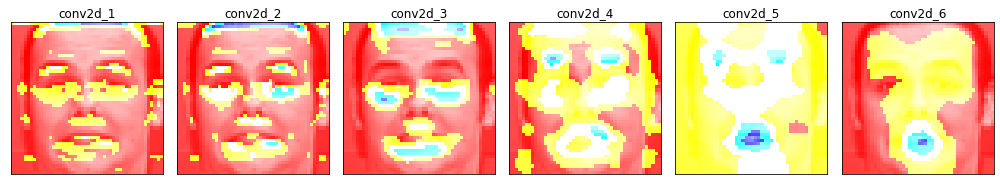

In [0]:
fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    img_hm = cv2.resize(img_heatmap, (48,48))
    img_hm = np.uint8(255 * img_hm)

    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = img_hm * 0.4 + sample_img

    ax = pyplot.subplot(1, 6, i+1)
    ax.imshow(superimposed_img[0,:,:])
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()